In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imread_collection, concatenate_images
# from skimage.io import imshow
from skimage.transform import resize
from skimage.morphology import label

from scipy import ndimage, misc

/Users/sullivan42/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load interpolated.csv to get steering angle, etc:

In [3]:
# interp_path = '/Users/James/Desktop/CS231_Proj_Res/interpolated_clean.csv'
interp_path = '/Users/sullivan42/workspace/cs231n_proj/cs231n_final_proj/data/output/interpolated_clean.csv'
interpolated = np.loadtxt(interp_path, delimiter=',')

#each column: timestamp, angle, torque, speed
print('Interpolated cleaned shape')
print(interpolated.shape)

#print out first and second center data for check (should be row 2 out of every 3)
print('\n\nALL DATA (LEFT, CENTER, RIGHT):')
print('\ntimestamp     angle     torque     speed')
print('center 0: ' + str(interpolated[1]))
print('center 1: ' + str(interpolated[4]))



Interpolated cleaned shape
(45636, 4)


ALL DATA (LEFT, CENTER, RIGHT):

timestamp     angle     torque     speed
center 0: [ 1.47519000e+18 -4.63138160e-02 -6.91982688e-01  1.46070442e+01]
center 1: [ 1.47519000e+18 -4.70994040e-02 -5.60746319e-01  1.46166668e+01]


In [4]:
#pull out all center data (row 2 out of every 3)

#print one line 
center_data = interpolated[1::3]

#sanity check to ensure we have center data, print out first two center data
print('CENTER DATA EXTRACTED:')
print('\ntimestamp     angle     torque     speed')
print('center 0: ' + str(center_data[0]))
print('center 1: '  + str(center_data[1]))

CENTER DATA EXTRACTED:

timestamp     angle     torque     speed
center 0: [ 1.47519000e+18 -4.63138160e-02 -6.91982688e-01  1.46070442e+01]
center 1: [ 1.47519000e+18 -4.70994040e-02 -5.60746319e-01  1.46166668e+01]


In [5]:
#Some more sanity checking, see if we can correctly pull out the angle data for a center row

center0 = center_data[0]
print(center0)
print(center0[1])


[ 1.47519000e+18 -4.63138160e-02 -6.91982688e-01  1.46070442e+01]
-0.046313816


In [6]:
#Extract steering angle data for all timesteps, for center data
y_train = center_data[:,1]

print(y_train.shape)
print(y_train[0])

num_train = y_train.shape[0]

(15212,)
-0.046313816


/Users/sullivan42/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1665, 240, 320, 3)


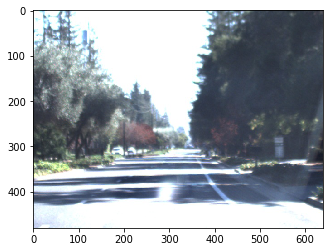

In [7]:
#Import the corresponding center camera images

img_height = 240
img_width = 320
img_channels = 3

og_height = 480
og_width = 640

num_center_sub = 1665

# train_path = '/Users/James/Desktop/CS231_Proj_Res/center_sub'
train_path = '/Users/sullivan42/workspace/cs231n_proj/cs231n_final_proj/data/output/center_sub'

X_train = np.zeros((num_center_sub, img_height, img_width, img_channels), dtype=np.float64)

i = 0

for root, dirnames, filenames in os.walk(train_path):
    for filename in filenames:
        if not filename.startswith('.') and filename != 'Thumbs.db':
#         if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
    
            image = plt.imread(filepath)
            image_resized = misc.imresize(image, (img_height, img_width, img_channels))
                
            X_train[i,:,:,:] = image_resized
            if i == 0:
                plt.imshow(image)
            
            X_train[i] = image_resized
            
            i += 1
                    

print(X_train.shape)

(240, 320, 3)
255.0


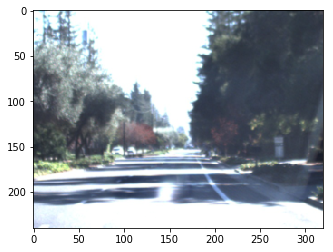

In [8]:
#plot a random resized image as sanity check
imga = X_train[0]
print(imga.shape)
print(np.max(imga))
plt.imshow(imga/255)

In [9]:
#get the correct number of train labels
y_train = y_train[:num_center_sub]
print(y_train.shape)

(1665,)


In [12]:
#Keras baseline CNN:

inputs = tf.keras.Input((img_height, img_width, img_channels))

#starting filter number
f = 10
#conv window size
k = 3
#max pool window size
mx = 2  

drop_rate = 0.3

input_shape = (img_height, img_width, img_channels)

c1 = tf.keras.layers.Conv2D(f, (k,k), activation = 'relu', padding = 'same')(inputs)
c1 = tf.keras.layers.Conv2D(f, (k,k), activation = 'relu', padding = 'same')(c1)

c1 = tf.keras.layers.Dropout(drop_rate)(c1)

m1 = tf.keras.layers.MaxPooling2D(mx)(c1)

c2 = tf.keras.layers.Conv2D(f*2, (k,k), activation = 'relu', padding = 'same')(m1)
c2 = tf.keras.layers.Conv2D(f*2, (k,k), activation = 'relu', padding = 'same')(c2)

c2 = tf.keras.layers.Dropout(drop_rate)(c2)

m2 = tf.keras.layers.MaxPooling2D(mx)(c2)

c3 = tf.keras.layers.Conv2D(f*4, (k,k), activation = 'relu', padding = 'same')(m2)
c3 = tf.keras.layers.Conv2D(f*4, (k,k), activation = 'relu', padding = 'same')(c3)

c3 = tf.keras.layers.Dropout(drop_rate)(c3)

f1 = tf.keras.layers.Flatten(input_shape = input_shape)(c3)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(f1)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name = 'Baseline CNN')
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# #train the U-Net model 
# # earlystopper = tf.keras.EarlyStopping(patience=5, verbose=1)
# # checkpointer = ModelCheckpoint('model-CS230', verbose=1, save_best_only=True)
# results = UNet_model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=10,  
#                     callbacks=[earlystopper, checkpointer])

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=5)

# s = Lambda(lambda x: x / 255) (inputs)
# # s = Lambda(lambda x: x)(inputs)

# c1 = Conv2D(f, (k,k), activation='relu', padding='same')(inputs)  
# c1 = Conv2D(f, (k,k), activation='relu', padding='same')(c1) #keep for concatenate
# p1 = MaxPooling2D(pool_size=(mx,mx), strides=2, padding='valid')(c1)

# c2 = Conv2D(f*2, (k,k), activation='relu', padding='same')(p1)
# c2 = Conv2D(f*2, (k,k), activation='relu', padding='same')(c2) #keep for concatenate
# p2 = MaxPooling2D(pool_size=(mx,mx), strides=2, padding='valid')(c2)

# c3 = Conv2D(f*4, (k,k), activation='relu', padding='same')(p2)
# c3 = Conv2D(f*4, (k,k), activation='relu', padding='same')(c3) #keep for concatenate
# p3 = MaxPooling2D(pool_size=(mx,mx), strides=2, padding='valid')(c3)

# c4 = Conv2D(f*8, (k,k), activation='relu', padding='same')(p3)
# c4 = Conv2D(f*8, (k,k), activation='relu', padding='same')(c4) #keep for concatenate

# u3 = UpSampling2D(size=(mx,mx), data_format=None)(c4)
# u3 = concatenate([u3, c3])
# u3 = Conv2D(f*4, (k,k), activation='relu', padding='same')(u3)
# u3 = Conv2D(f*4, (k,k), activation='relu', padding='same')(u3)

# u2 = UpSampling2D(size=(mx,mx), data_format=None)(u3)
# u2 = concatenate([u2, c2])
# u2 = Conv2D(f*2, (k,k), activation='relu', padding='same')(u2)
# u2 = Conv2D(f*2, (k,k), activation='relu', padding='same')(u2)

# u1 = UpSampling2D(size=(mx,mx), data_format=None)(u2)
# u1 = concatenate([u1,c1])
# u1 = Conv2D(f, (k,k), activation='relu', padding='same')(u1)
# u1 = Conv2D(f, (k,k), activation='relu', padding='same')(u1)            
         

# outputs = Conv2D(1, (k,k), activation='sigmoid', padding='same')(u1)

# UNet_model = Model(inputs=[inputs], outputs=[outputs], name = 'U-Net')
# UNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
# UNet_model.summary()

# #train the U-Net model 
# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model-CS230', verbose=1, save_best_only=True)
# results = UNet_model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10,  
#                     callbacks=[earlystopper, checkpointer])

# # Predict on train, val and test using U-Net
# model = load_model('model-CS230', custom_objects={'dice_coef': dice_coef})
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) #what does verbose argument do?
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 240, 320, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 240, 320, 10)      280       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 240, 320, 10)      910       
_________________________________________________________________
dropout_1 (Dropout)          (None, 240, 320, 10)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 120, 160, 10)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 120, 160, 20)      1820      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 120, 160, 20)      3620      
__________

You can optionally **use GPU by setting the flag to True below**. It's not neccessary to use a GPU for this assignment; if you are working on Google Cloud then we recommend that you do not use a GPU, as it will be significantly more expensive.

In [85]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


# Part IV: Keras Sequential API
In Part III we introduced the `tf.keras.Model` API, which allows you to define models with any number of learnable layers and with arbitrary connectivity between layers.

However for many models you don't need such flexibility - a lot of models can be expressed as a sequential stack of layers, with the output of each layer fed to the next layer as input. If your model fits this pattern, then there is an even easier way to define your model: using `tf.keras.Sequential`. You don't need to write any custom classes; you simply call the `tf.keras.Sequential` constructor with a list containing a sequence of layer objects.

One complication with `tf.keras.Sequential` is that you must define the shape of the input to the model by passing a value to the `input_shape` of the first layer in your model.

### Keras Sequential API: Two-Layer Network
Here we rewrite the two-layer fully-connected network using `tf.keras.Sequential`, and train it using the training loop defined above.

You don't need to perform any hyperparameter tuning here, but you should see accuracies above 40% after training for one epoch.

In [71]:
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    input_shape = (32, 32, 3)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [
        tf.layers.Flatten(input_shape=input_shape),
        tf.layers.Dense(hidden_layer_size, activation=tf.nn.relu,
                        kernel_initializer=initializer),
        tf.layers.Dense(num_classes, kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.5710
Got 142 / 1000 correct (14.20%)

Iteration 100, loss = 1.8217
Got 385 / 1000 correct (38.50%)

Iteration 200, loss = 1.4323
Got 410 / 1000 correct (41.00%)

Iteration 300, loss = 1.6296
Got 401 / 1000 correct (40.10%)

Iteration 400, loss = 1.6882
Got 428 / 1000 correct (42.80%)

Iteration 500, loss = 1.7437
Got 452 / 1000 correct (45.20%)

Iteration 600, loss = 1.9082
Got 448 / 1000 correct (44.80%)

Iteration 700, loss = 1.8337
Got 460 / 1000 correct (46.00%)



### Keras Sequential API: Three-Layer ConvNet
Here you should use `tf.keras.Sequential` to reimplement the same three-layer ConvNet architecture used in Part II and Part III. As a reminder, your model should have the following architecture:

1. Convolutional layer with 16 5x5 kernels, using zero padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 32 3x3 kernels, using zero padding of 1
4. ReLU nonlinearity
5. Fully-connected layer giving class scores

You should initialize the weights of the model using a `tf.variance_scaling_initializer` as above.

You should train the model using Nesterov momentum 0.9.

You don't need to perform any hyperparameter search, but you should achieve accuracy above 45% after training for one epoch.

In [75]:
def model_init_fn(inputs, is_training):
    model = None
    ############################################################################
    # TODO: Construct a three-layer ConvNet using tf.keras.Sequential.         #
    ############################################################################
    input_shape = (32, 32, 3)
    channel_1, channel_2, num_classes = 16, 32, 10
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [
        tf.layers.Conv2D(channel_1, activation=tf.nn.relu, padding='same',
                                   kernel_initializer=initializer, kernel_size=(5,5)),
        tf.layers.Conv2D(channel_2, activation=tf.nn.relu,padding='same',
                                   kernel_initializer=initializer, kernel_size=(3,3)),
        
        tf.layers.Flatten(input_shape=input_shape),
        tf.layers.Dense(num_classes,
                                   kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model(inputs)

learning_rate = 5e-4
def optimizer_init_fn():
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.4234
Got 122 / 1000 correct (12.20%)

Iteration 100, loss = 1.7614
Got 413 / 1000 correct (41.30%)

Iteration 200, loss = 1.5625
Got 460 / 1000 correct (46.00%)

Iteration 300, loss = 1.6074
Got 476 / 1000 correct (47.60%)

Iteration 400, loss = 1.5186
Got 502 / 1000 correct (50.20%)

Iteration 500, loss = 1.5957
Got 521 / 1000 correct (52.10%)

Iteration 600, loss = 1.5241
Got 524 / 1000 correct (52.40%)

Iteration 700, loss = 1.5925
Got 522 / 1000 correct (52.20%)



# Part V: CIFAR-10 open-ended challenge

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with architectures, hyperparameters, loss functions, regularization, or anything else you can think of to train a model that achieves **at least 70%** accuracy on the **validation** set within 10 epochs. You can use the `check_accuracy` and `train` functions from above, or you can implement your own training loop.

Describe what you did at the end of the notebook.

### Some things you can try:
- **Filter size**: Above we used 5x5 and 3x3; is this optimal?
- **Number of filters**: Above we used 16 and 32 filters. Would more or fewer do better?
- **Pooling**: We didn't use any pooling above. Would this improve the model?
- **Normalization**: Would your model be improved with batch normalization, layer normalization, group normalization, or some other normalization strategy?
- **Network architecture**: The ConvNet above has only three layers of trainable parameters. Would a deeper model do better?
- **Global average pooling**: Instead of flattening after the final convolutional layer, would global average pooling do better? This strategy is used for example in Google's Inception network and in Residual Networks.
- **Regularization**: Would some kind of regularization improve performance? Maybe weight decay or dropout?

### WARNING: Batch Normalization / Dropout
Batch Normalization and Dropout **WILL NOT WORK CORRECTLY** if you use the `train_part34()` function with the object-oriented `tf.keras.Model` or `tf.keras.Sequential` APIs; if you want to use these layers with this training loop then you **must use the tf.layers functional API**.

We wrote `train_part34()` to explicitly demonstrate how TensorFlow works; however there are some subtleties that make it tough to handle the object-oriented batch normalization layer in a simple training loop. In practice both `tf.keras` and `tf` provide higher-level APIs which handle the training loop for you, such as [keras.fit](https://keras.io/models/sequential/) and [tf.Estimator](https://www.tensorflow.org/programmers_guide/estimators), both of which will properly handle batch normalization when using the object-oriented API.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
### Have fun and happy training! 

In [103]:
def model_init_fn(inputs, is_training):
    model = None
    ############################################################################
    # TODO: Construct a model that performs well on CIFAR-10                   #
    ############################################################################
    input_shape = (32, 32, 3)
    channel_1, channel_2, channel_3, channel_4, num_classes = 32, 32, 16, 16, 10
    initializer = tf.variance_scaling_initializer(scale=2.0)
    reglzr = tf.contrib.layers.l2_regularizer(0.5)
    layers = [
        #leaky relu!
        tf.layers.Conv2D(channel_1, activation=tf.nn.leaky_relu, padding='same',
                                   kernel_initializer=initializer, 
                                   kernel_size=(3,3),
                                   kernel_regularizer = reglzr),
        tf.keras.layers.Dropout(0.5),
        
        tf.layers.Conv2D(channel_2, activation=tf.nn.leaky_relu,padding='same',
                                   kernel_initializer=initializer, 
                                   kernel_size=(3,3),
                                   kernel_regularizer = reglzr),
        
        tf.keras.layers.Dropout(0.5),
        
        tf.layers.Conv2D(channel_3, activation=tf.nn.leaky_relu,padding='same',
                                   kernel_initializer=initializer, 
                                   kernel_size=(5,5),
                                   kernel_regularizer = reglzr),
        tf.keras.layers.Dropout(0.5),
        
         tf.layers.Conv2D(channel_4, activation=tf.nn.leaky_relu,padding='same',
                                   kernel_initializer=initializer, 
                                   kernel_size=(5,5),
                                   kernel_regularizer = reglzr),
        
        tf.layers.Flatten(input_shape=input_shape),
        tf.layers.Dense(num_classes,
                                   kernel_initializer=initializer,
                                   kernel_regularizer = reglzr),
    ]
    model = tf.keras.Sequential(layers)
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model(inputs)

pass

def optimizer_init_fn():
    learning_rate = 5e-4
#     optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    optimizer = tf.train.AdamOptimizer(learning_rate)  
    ############################################################################
    # TODO: Construct an optimizer that performs well on CIFAR-10              #
    ############################################################################
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return optimizer

# device = '/gpu:0'
print_every = 200
num_epochs = 5
train_part34(model_init_fn, optimizer_init_fn, num_epochs)

Starting epoch 0
Iteration 0, loss = 2.7101
Got 116 / 1000 correct (11.60%)

Iteration 200, loss = 1.2512
Got 500 / 1000 correct (50.00%)

Iteration 400, loss = 1.2807
Got 530 / 1000 correct (53.00%)

Iteration 600, loss = 1.2459
Got 566 / 1000 correct (56.60%)

Starting epoch 1
Iteration 800, loss = 1.1611
Got 593 / 1000 correct (59.30%)

Iteration 1000, loss = 0.9283
Got 605 / 1000 correct (60.50%)

Iteration 1200, loss = 1.0365
Got 604 / 1000 correct (60.40%)

Iteration 1400, loss = 1.0791
Got 645 / 1000 correct (64.50%)

Starting epoch 2
Iteration 1600, loss = 0.7626
Got 640 / 1000 correct (64.00%)

Iteration 1800, loss = 0.6181
Got 631 / 1000 correct (63.10%)

Iteration 2000, loss = 0.6942
Got 636 / 1000 correct (63.60%)

Iteration 2200, loss = 0.9034
Got 624 / 1000 correct (62.40%)

Starting epoch 3
Iteration 2400, loss = 0.7391
Got 636 / 1000 correct (63.60%)

Iteration 2600, loss = 0.5824
Got 632 / 1000 correct (63.20%)

Iteration 2800, loss = 0.7700
Got 643 / 1000 correct (64.

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

TODO: Tell us what you did

I began with the baseline model that we developed and added two extra convolutional layers in order to further build the architecture's representational power. Then I added regularization techniques (3 dropout layers, L2 regularization to all layers) to help prevent overfitting, hopefully to allow for better generalization to the validation set. I also experiemented with leaky ReLU's as the activation functions in hopes of enhancing the training process (just in case there were any dying ReLU's).